In [1]:
from iuvs import io, hk

In [2]:
hkfiles = io.get_hk_filenames()

In [3]:
hkfiles[0]

'/maven_iuvs/production/products/housekeeping/level1a/mvn_iuv_analog_l0_20140610_v001.fits.gz'

In [1]:
from pathlib import Path

In [2]:
p = Path('/maven_iuvs/production/products/housekeeping/level1a/mvn_iuv_analog_l0_20140610_v001.fits.gz')

In [5]:
p.with_suffix('.h5')

PosixPath('/maven_iuvs/production/products/housekeeping/level1a/mvn_iuv_analog_l0_20140610_v001.fits.h5')

In [12]:
p.root

'/'

In [4]:
hkdata = hk.HKReader(hkfiles[0])

In [5]:
timestamp_ = hkdata.AnalogConv['SC_CLK_COARSE']
ss = hkdata.AnalogConv['SC_CLK_FINE']

In [6]:
from iuvs.spice import load_kernels
import SpiceyPy as spice
load_kernels()

In [7]:
mavenid, _ = spice.bodn2c('MAVEN')

In [8]:
timestamp = timestamp_ + ss/65536  # timestamp_ and ss are already float
timestamp

array([  4.55630416e+08,   4.55630446e+08,   4.55630476e+08, ...,
         4.55716727e+08,   4.55716757e+08,   4.55716787e+08])

In [9]:
sec = np.uint64(timestamp)
subsec = np.uint64((timestamp-sec)*65536)

In [10]:
def format_times(sec,subsec):
    return "{:010d}.{:05d}".format(int(sec), int(subsec))

In [11]:
sclkch = np.vectorize(format_times)(sec, subsec)

In [12]:
sclkdp = np.vectorize(spice.scencd)(mavenid, sclkch)

In [13]:
et = np.vectorize(spice.sct2e)(mavenid, sclkdp)

In [14]:
utc = np.vectorize(spice.et2utc)(et, 'ISOC', 50, 100)

In [15]:
utc = pd.to_datetime(utc)

In [16]:
pd.Series(utc).head()

0   2014-06-10 00:00:21.931559562
1   2014-06-10 00:00:51.931587815
2   2014-06-10 00:01:21.931616067
3   2014-06-10 00:01:51.931644320
4   2014-06-10 00:02:21.931672573
dtype: datetime64[ns]

In [17]:
import sys
d = {}
for col in hkdata.temp_cols:
    data = hkdata.AnalogConv[col]
    sys_byteorder = ('>', '<')[sys.byteorder == 'little']
    if data.dtype.byteorder not in ('=', sys_byteorder):
        d[col] = data.byteswap().newbyteorder(sys_byteorder)
    else:
        d[col] = data

In [18]:
df = pd.DataFrame(d)

In [20]:
df.index = utc

In [23]:
df.head()

,FUV_CHIP_TEMP_C,FUV_DET_TEMP_C,FUV_INT_TEMP_C,GRAT_MOT_TEMP_C,HV_POWR_TEMP_C,IUVS_1_TEMP_C,IUVS_2_TEMP_C,IUVS_3_TEMP_C,IUVS_4_TEMP_C,IUVS_5_TEMP_C,...,MUV_DET_TEMP_C,MUV_INT_TEMP_C,OP_1_HTR_TEMP_C,OP_2_HTR_TEMP_C,POWER_BD1_TEMP_C,POWER_BD2_TEMP_C,PROC_BD_TEMP_C,SCAN_MOT_TEMP_C,ZONE_1_HTR_TEMP_C,ZONE_2_HTR_TEMP_C
2014-06-10 00:00:21.931559562,-11.1477,-10.097055,-12.064343,4.610076,7.258748,3.506278,4.861658,4.065676,4.553584,-57.451949,...,-12.296110,-14.360906,-14.781463,-17.296204,-14.367775,-16.233224,-16.283014,2.901151,5.761817,5.456265
2014-06-10 00:00:51.931587815,-11.0728,-10.097055,-12.057734,4.616355,7.284869,3.506278,4.861658,4.059440,4.547309,-57.451949,...,-12.302745,-14.367775,-14.788384,-17.426993,-14.347170,-16.204794,-16.268783,2.894996,5.768197,5.456265
2014-06-10 00:01:21.931616067,-11.1477,-10.097055,-12.057734,4.610076,7.297934,3.506278,4.855359,4.059440,4.547309,-57.466701,...,-12.309380,-14.367775,-14.795306,-17.528951,-14.326573,-16.190584,-16.261670,2.901151,5.761817,5.456265
2014-06-10 00:01:51.931644320,-11.0728,-10.090630,-12.064343,4.616355,7.317536,3.506278,4.861658,4.065676,4.553584,-57.451949,...,-12.296110,-14.374644,-14.788384,-17.609204,-14.312846,-16.183481,-16.247445,2.907306,5.761817,5.462617
2014-06-10 00:02:21.931672573,-11.0728,-10.097055,-12.057734,4.603797,7.324071,3.512474,4.861658,4.065676,4.547309,-57.466701,...,-12.289477,-14.374644,-14.795306,-17.674960,-14.292262,-16.169277,-16.240334,2.894996,5.768197,5.462617


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2880 entries, 2014-06-10 00:00:21.931559562 to 2014-06-10 23:59:52.658632993
Data columns (total 21 columns):
FUV_CHIP_TEMP_C      2880 non-null float64
FUV_DET_TEMP_C       2880 non-null float64
FUV_INT_TEMP_C       2880 non-null float64
GRAT_MOT_TEMP_C      2880 non-null float64
HV_POWR_TEMP_C       2880 non-null float64
IUVS_1_TEMP_C        2880 non-null float64
IUVS_2_TEMP_C        2880 non-null float64
IUVS_3_TEMP_C        2880 non-null float64
IUVS_4_TEMP_C        2880 non-null float64
IUVS_5_TEMP_C        2880 non-null float64
MUV_CHIP_TEMP_C      2880 non-null float64
MUV_DET_TEMP_C       2880 non-null float64
MUV_INT_TEMP_C       2880 non-null float64
OP_1_HTR_TEMP_C      2880 non-null float64
OP_2_HTR_TEMP_C      2880 non-null float64
POWER_BD1_TEMP_C     2880 non-null float64
POWER_BD2_TEMP_C     2880 non-null float64
PROC_BD_TEMP_C       2880 non-null float64
SCAN_MOT_TEMP_C      2880 non-null float64
ZONE_1_HTR_TEMP_C   

<IPython.core.display.Javascript object>


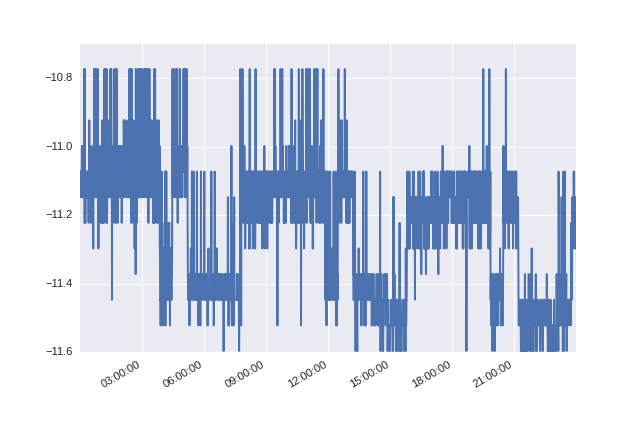

In [26]:
df.FUV_CHIP_TEMP_C.plot()